In [2]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import libpysal as ps
import numpy as np
import geopandas
import shapely.wkt

In [2]:
def stringpoly_to_poly(data):
    """
    Changes the Multipolygon string into Polygon or Multipolygon class. 
    Usefull for for example Apotheken dataset.
    
    input: geom column with Polygon as string
    Returns: new column consisting of Polygon class
    """ 
    new_geom = [] # List to keep new column
    
    for i, geom in enumerate(data):
        
        # Convert string to (multi)Polygon class
        P = shapely.wkt.loads(geom)
        
        # If Multipolygon is only of length 1: change to Polygon
        if len(P.geoms) == 1:
            P = list(P)[0]
        new_geom.append(P)
            
    return new_geom
        

In [3]:
bag = pd.read_csv("../Data/vbo_pand.csv", sep = ";", encoding='latin-1')

# # identificatie links to pand_id from the BAG dataset
# typering = pd.read_csv("../Data/Woningtypering.csv")
# typering["begindatum"] =  pd.to_datetime(typering['begindatum'], format='%Y%m%d%H%M%S%f', errors='coerce')

# pand_grid = pd.read_csv("../Data/20210903_pand_grid_kruising.csv", delimiter = ";")
# pand_grid["opp"] = pd.to_numeric(pand_grid["opp"].astype("str").str.replace(",", ""))

# apotheken = pd.read_csv("../Data/grid_apotheken.csv")
# apotheken["the_geom"] = stringpoly_to_poly(apotheken["the_geom"])

C:\Users\Gebruiker\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
print(bag.shape)

(9162119, 23)


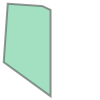

In [4]:
apotheken.the_geom[0]

In [91]:
eindhoven = bag[bag["gemeente"] == "Amsterdam"]
print(eindhoven.shape)
samen = eindhoven.join(typering.set_index("identificatie"), on = "pandid")
print(samen.shape)
# There can be buildings in multiple grids.
samen = samen.join(pand_grid.set_index("pand_id"), on = "pandid")
print(samen.shape)
samen = samen.join(apotheken.set_index("id_grid"), on = "lb_gridcod")
print(samen.shape)

(522573, 23)
(522573, 47)
(918676, 50)
(918676, 52)


In [82]:
print(eindhoven.columns)
print(samen.Aantal_VBO.sum())

Index(['object_id', 'pandid', 'openbareruimte', 'huisnummer', 'huisletter',
       'huisnummertoevoeging', 'postcode', 'woonplaats', 'gemeente',
       'provincie', 'nummeraanduiding', 'verblijfsobjectgebruiksdoel',
       'oppervlakteverblijfsobject', 'verblijfsobjectstatus', 'object_type',
       'nevenadres', 'pandstatus', 'pandbouwjaar', 'x', 'y', 'lon', 'lat',
       'verkorteopenbareruimte'],
      dtype='object')
42858390.0


In [49]:
samen.to_csv("../Data/eindhoven.csv")


In [80]:
samen.provincie

6668442    Noord-Brabant
6668442    Noord-Brabant
6668443    Noord-Brabant
6668444    Noord-Brabant
6668445    Noord-Brabant
               ...      
6794000    Noord-Brabant
6794001    Noord-Brabant
6794001    Noord-Brabant
6794002    Noord-Brabant
6794003    Noord-Brabant
Name: provincie, Length: 204062, dtype: object

# Grid bebouwing:


In [62]:
samen = pd.read_csv("../Data/eindhoven.csv")
apotheken = pd.read_csv("../Data/grid_apotheken.csv")

C:\Users\Gebruiker\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
def dichtheid(data):
    """
    input: data containing (atleast) typering data and lb_gridcod
    output: number VBO and number x.functie per grid
    """
    
    data = data[['Aantal_VBO', 'woonfunctie',
       'bijeenkomstfunctie', 'celfunctie', 'gezondheidszorgfunctie',
       'industriefunctie', 'kantoorfunctie', 'logiesfunctie',
       'onderwijsfunctie', 'sportfunctie', 'winkelfunctie',
       'overige_gebruiksfunctie', "lb_gridcod"]]
    
    
    data = data.groupby(by = 'lb_gridcod').sum()
    return data
    

In [92]:
dens = dichtheid(samen)
print(dens.shape)
dens = dens.join(apotheken.set_index("id_grid"), on = "lb_gridcod")
print(dens.shape)
dens.columns
dens.rename(columns = {'the_geom':'geometry'}, inplace = True)

(7627, 12)
(7627, 14)


In [86]:
geo_df.geometry

lb_gridcod
1402339.0    POLYGON ((168464.963 359912.528, 168447.726 35...
1402344.0    POLYGON ((168942.198 360000.000, 168954.810 36...
1404981.0    POLYGON ((168400.000 360037.556, 168397.473 36...
1404982.0    POLYGON ((168416.399 360040.290, 168416.546 36...
1404986.0    POLYGON ((168836.349 360049.771, 168834.247 36...
                                   ...                        
3162516.0    POLYGON ((162400.000 426581.118, 162397.777 42...
3162520.0    POLYGON ((162800.000 426510.006, 162800.000 42...
3162521.0    POLYGON ((162809.625 426500.000, 162800.000 42...
3165159.0    POLYGON ((162400.000 426600.000, 162367.227 42...
3165160.0    POLYGON ((162427.771 426600.000, 162400.000 42...
Name: geometry, Length: 109997, dtype: geometry

In [93]:
geo_df = gpd.GeoDataFrame(dens[['Aantal_VBO', 'woonfunctie', 'bijeenkomstfunctie', 'celfunctie',
       'gezondheidszorgfunctie', 'industriefunctie', 'kantoorfunctie',
       'logiesfunctie', 'onderwijsfunctie', 'sportfunctie', 'winkelfunctie',
       'overige_gebruiksfunctie', 'geometry']])


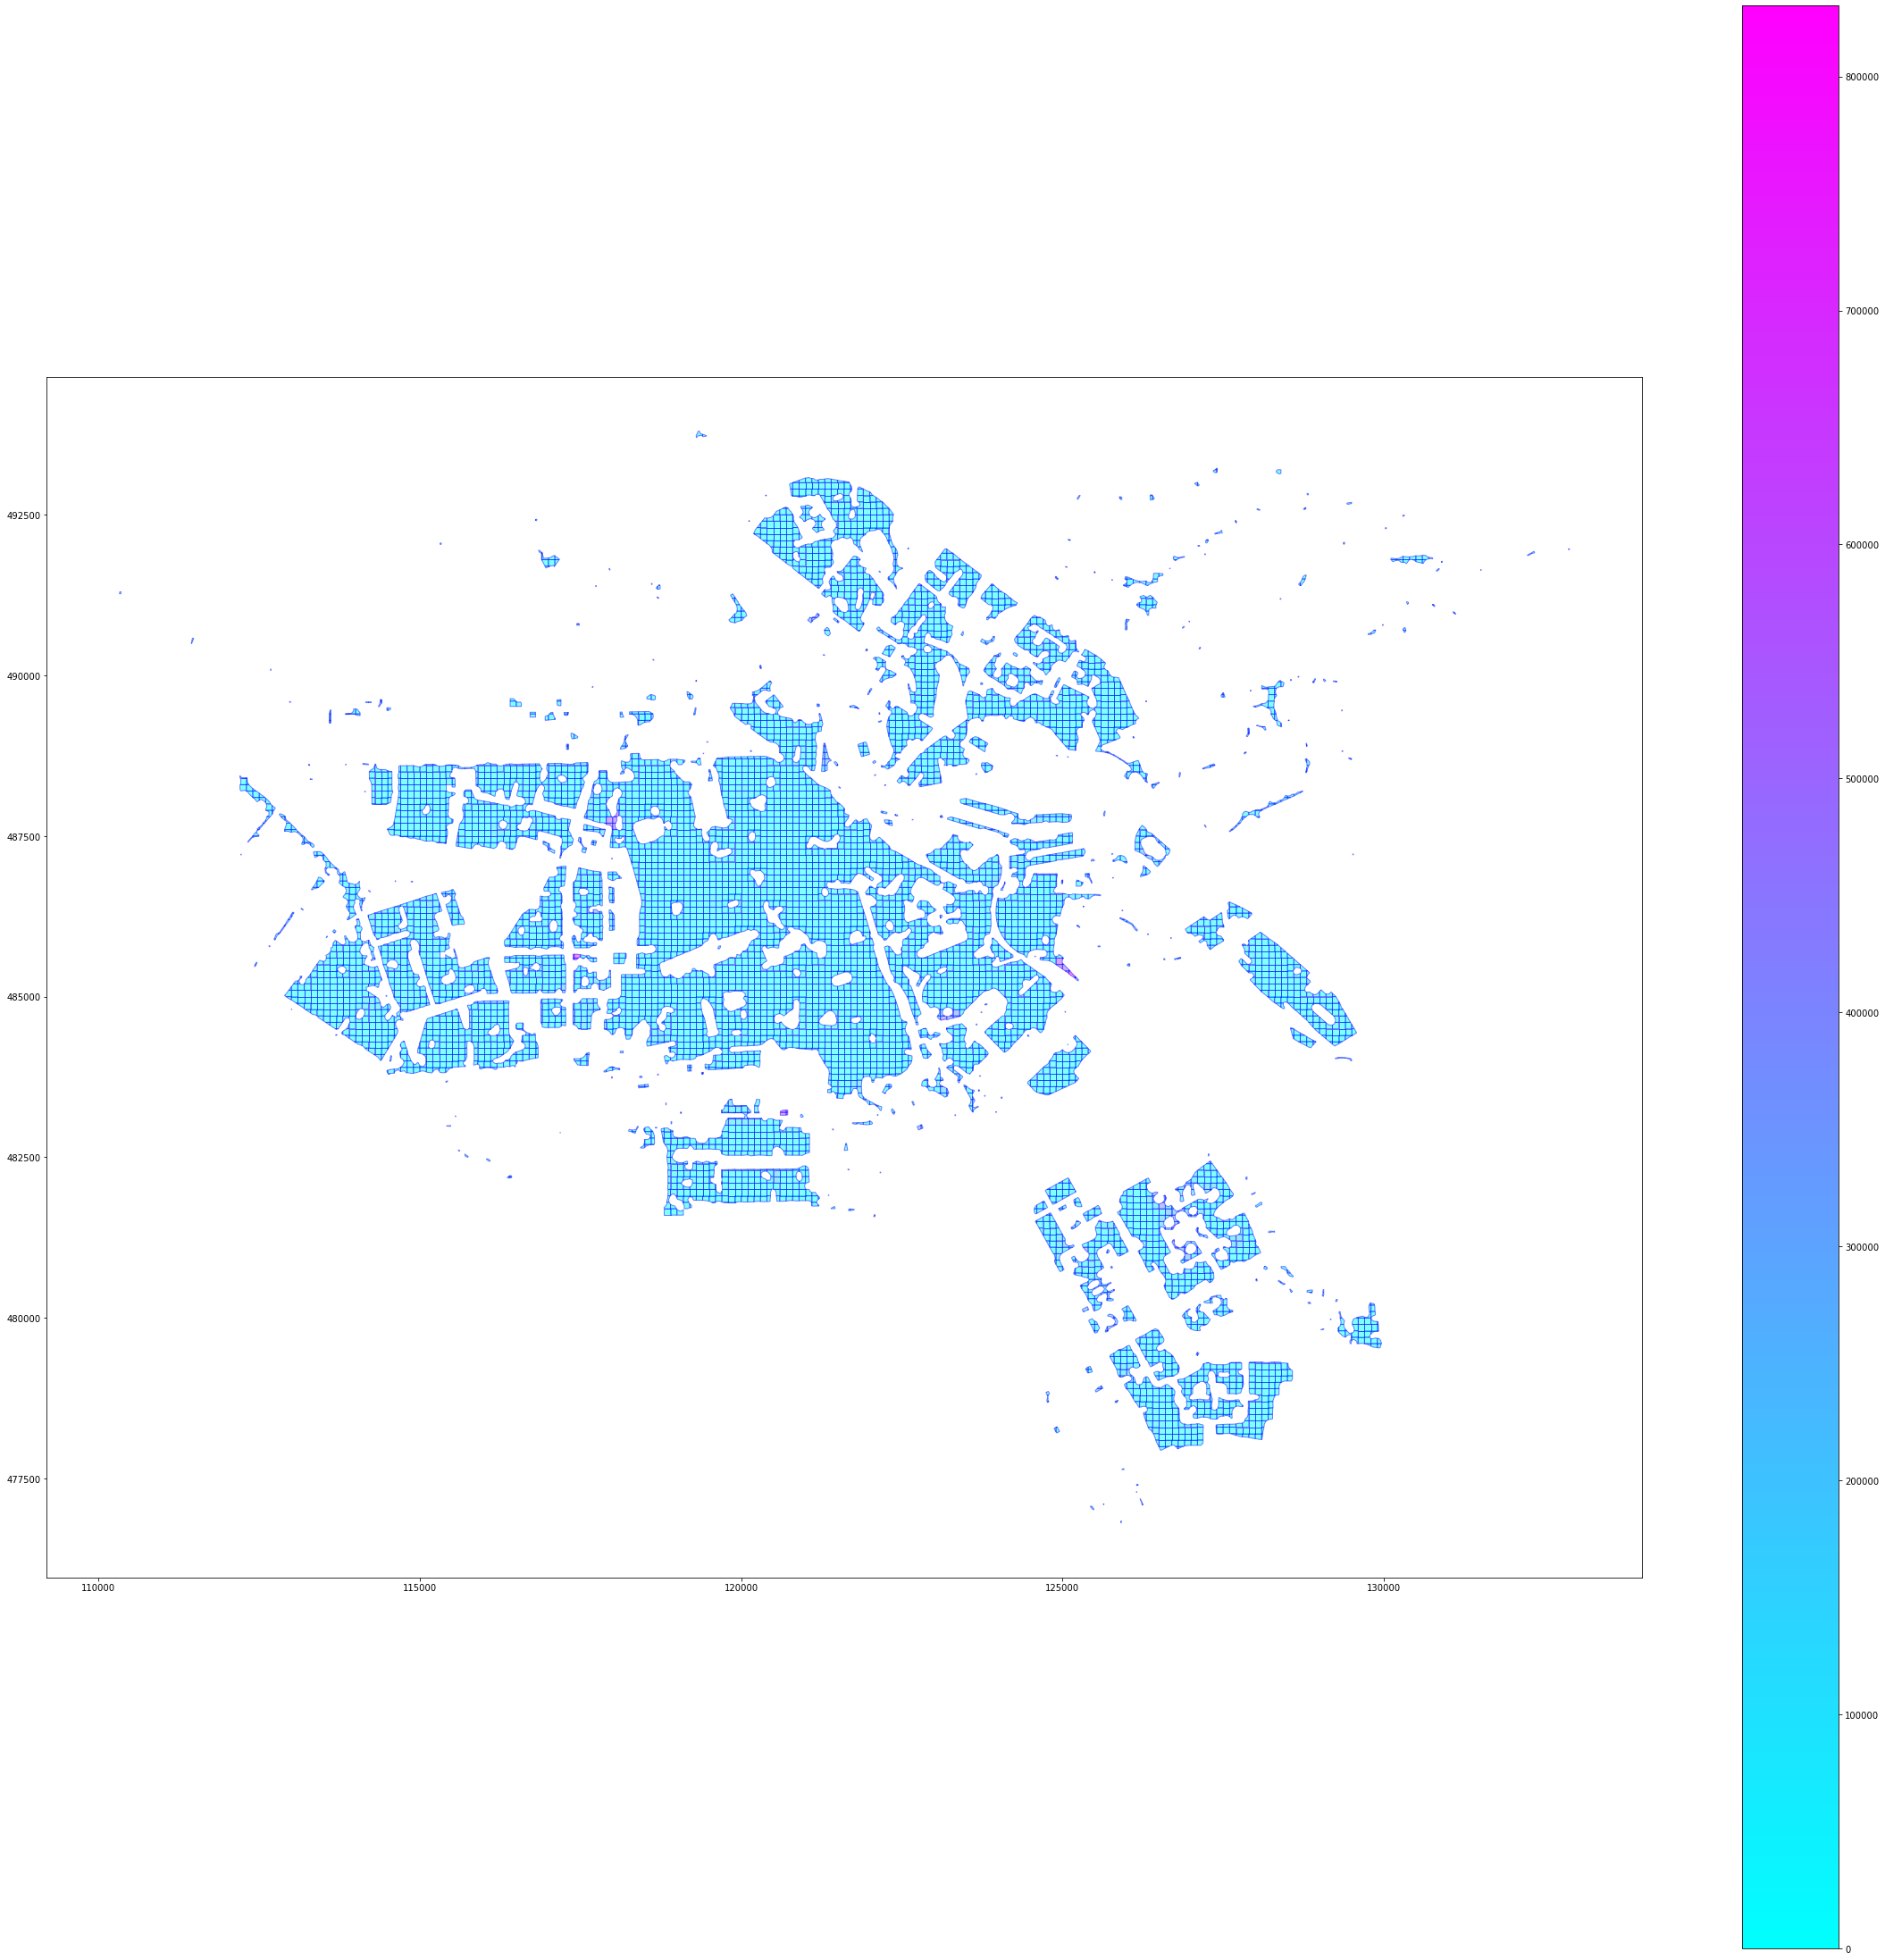

In [95]:
ax = geo_df.plot(figsize=(40, 40), alpha=0.5, edgecolor = "b", column='woonfunctie',cmap='cool',legend=True)
plt.savefig("AM.jpg")
# geo_df['coords'] = geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
# geo_df['coords'] = [coords[0] for coords in geo_df['coords']]

# for idx, row in geo_df.iterrows():
#     plt.annotate(text=row["woonfunctie"], xy=row['coords'],horizontalalignment='center')


In [38]:
geo_df.Aantal_VBO.sum()

10535068.0